# Housing Model Training Pipeline
This notebook demonstrates a complete machine learning pipeline for the California housing dataset, including preprocessing, model training, and evaluation.

## 1. Import Libraries
Import all necessary libraries for data processing, transformation, modeling, and evaluation.

In [3]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

## 2. Define Custom Transformer
The `ClusterSimilarity` transformer creates geographic cluster features using KMeans clustering.

In [4]:
class ClusterSimilarity(BaseEstimator, TransformerMixin):
    """
    Creates features based on similarity to geographic clusters
    
    Parameters:
    n_clusters : Number of clusters to create
    gamma : Controls the influence radius of clusters
    random_state : Random seed for reproducibility
    """
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state
    
    def fit(self, X, y=None, sample_weight=None):
        if hasattr(X, "values"):
            X = X.values
        self.kmeans_ = KMeans(n_clusters=self.n_clusters, 
                             random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self
    
    def transform(self, X):
        if hasattr(X, "values"):
            X = X.values
        distances = np.linalg.norm(X[:, np.newaxis] - self.kmeans_.cluster_centers_, 
                                 axis=2)
        return np.exp(-self.gamma * distances ** 2)
    
    def get_params(self, deep=True):
        return {"n_clusters": self.n_clusters, 
                "gamma": self.gamma, 
                "random_state": self.random_state}
    
    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        return self

## 3. Load and Prepare Data
Load the housing dataset and create stratified train/test splits based on income categories.

In [5]:
def load_housing_data():
    """Load California housing dataset from remote URL"""
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

# Load and prepare data
housing = load_housing_data()

# Create income categories for stratified sampling
housing["income_cat"] = pd.cut(
    housing["median_income"],
    bins=[0.0, 1.5, 3.0, 4.5, 6.0, np.inf],
    labels=[1, 2, 3, 4, 5]
)

# Split into stratified train/test sets
strat_train_set, strat_test_set = train_test_split(
    housing,
    test_size=0.2,
    stratify=housing["income_cat"],
    random_state=42
)

# Prepare training data
housing = strat_train_set.drop(["median_house_value", "income_cat"], axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

## 4. Define Transformation Pipelines
Create custom transformation pipelines for different feature types including ratio features, log transformations, and categorical encoding.

In [6]:
# Helper functions for ratio features
def column_ratio(X):
    """Calculate ratio between two columns"""
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    """Generate feature name for ratio features"""
    return ["ratio"]

# Pipeline for ratio features
def ratio_pipeline():
    """Pipeline for ratio features: Impute → Calculate ratio → Scale"""
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler()
    )

# Pipeline for log-transformed features
log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler()
)

# Pipeline for categorical features
cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore")
)

# Default pipeline for numeric features
default_num_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
)

# Initialize geographic similarity transformer
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1.0, random_state=42)

## 5. Create Column Transformer
Combine all pipelines into a single preprocessing pipeline using ColumnTransformer.

In [7]:
preprocessing = ColumnTransformer([
    # Bedrooms to rooms ratio
    ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
    
    # Rooms per household
    ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
    
    # Population per household
    ("people_per_house", ratio_pipeline(), ["population", "households"]),
    
    # Log-transformed features
    ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                         "households", "median_income"]),
    
    # Geographic cluster similarity
    ("geo", cluster_simil, ["latitude", "longitude"]),
    
    # Categorical feature (ocean proximity)
    ("cat", cat_pipeline, ["ocean_proximity"])
], 
# Handle remaining numeric features
remainder=default_num_pipeline)

## 6. Apply Preprocessing
Transform the training data and verify the output feature matrix.

In [8]:
# Apply the full preprocessing pipeline
housing_prepared = preprocessing.fit_transform(housing)

# Display resulting feature matrix shape
print("Preprocessed data shape:", housing_prepared.shape)
print("\nExpected features breakdown:")
print("  - 3 ratio features")
print("  - 5 log-transformed features")
print("  - 10 geographic similarity features")
print("  - 5 one-hot encoded categories")
print("  - 1 remaining numeric feature")
print("Total: 24 features")

Preprocessed data shape: (16512, 24)

Expected features breakdown:
  - 3 ratio features
  - 5 log-transformed features
  - 10 geographic similarity features
  - 5 one-hot encoded categories
  - 1 remaining numeric feature
Total: 24 features


## 7. Train and Evaluate Linear Regression
Train a Linear Regression model and evaluate using Root Mean Squared Error (RMSE).

In [9]:
# Create pipeline with preprocessing and linear regression
lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)

# Make predictions
housing_predictions = lin_reg.predict(housing)

# Calculate RMSE
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
print(f"Linear Regression RMSE: ${lin_rmse:,.2f}")

Linear Regression RMSE: $68,972.89


## 8. Train and Evaluate Decision Tree
Train a Decision Tree Regressor and compare performance with Linear Regression.

In [10]:
# Create pipeline with preprocessing and decision tree
tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing, housing_labels)

# Make predictions
housing_predictions = tree_reg.predict(housing)

# Calculate RMSE
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
print(f"Decision Tree RMSE: ${tree_rmse:,.2f}")
print(f"\nImprovement over Linear Regression: {lin_rmse - tree_rmse:,.2f}")

Decision Tree RMSE: $0.00

Improvement over Linear Regression: 68,972.89


## 9. Evaluate Decision Tree with Cross-Validation
Decision Trees are prone to overfitting. We'll use cross-validation to get a more reliable performance estimate:

Explanation:

* Uses 10-fold cross-validation to evaluate model performance
* Negative RMSE scoring is used because scikit-learn convention is to maximize scores
* Results show mean performance and variability across folds
* Helps detect overfitting by showing performance consistency

In [11]:
from sklearn.model_selection import cross_val_score

# Evaluate Decision Tree with 10-fold cross-validation
tree_scores = -cross_val_score(tree_reg, housing, housing_labels,
                              scoring="neg_root_mean_squared_error", cv=10)

# Display performance metrics
tree_rmse_stats = pd.Series(tree_scores).describe()
print("Decision Tree Cross-Validation RMSE Statistics:")
print(tree_rmse_stats)

Decision Tree Cross-Validation RMSE Statistics:
count       10.000000
mean     66573.734600
std       1103.402323
min      64607.896046
25%      66204.731788
50%      66388.272499
75%      66826.257468
max      68532.210664
dtype: float64


## 10. Train and Evaluate Random Forest Model
Random Forests often outperform individual Decision Trees by combining multiple trees:

Explanation:

* Random Forest builds multiple decision trees and averages their predictions
* Handles overfitting better than single Decision Trees
* Generally provides higher accuracy and robustness
* Cross-validation gives reliable performance estimate

In [13]:
from sklearn.ensemble import RandomForestRegressor

# Create pipeline with preprocessing and Random Forest
forest_reg = make_pipeline(preprocessing,
                          RandomForestRegressor(random_state=42))

# Evaluate with cross-validation
forest_scores = -cross_val_score(forest_reg, housing, housing_labels,
                                scoring="neg_root_mean_squared_error", cv=10)

# Display performance metrics
forest_rmse_stats = pd.Series(forest_scores).describe()
print("\nRandom Forest Cross-Validation RMSE Statistics:")
print(forest_rmse_stats)


Random Forest Cross-Validation RMSE Statistics:
count       10.000000
mean     47038.092799
std       1021.491757
min      45495.976649
25%      46510.418013
50%      47118.719249
75%      47480.519175
max      49140.832210
dtype: float64


## 11. Model Comparison
Compare model performance using cross-validation results:


Model Comparison (Mean RMSE):
   Linear Regression  Decision Tree  Random Forest
0       68972.889108     66573.7346   47038.092799


C:\Users\PC\AppData\Local\Temp\ipykernel_8904\1591146127.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([tree_scores, forest_scores], labels=['Decision Tree', 'Random Forest'])


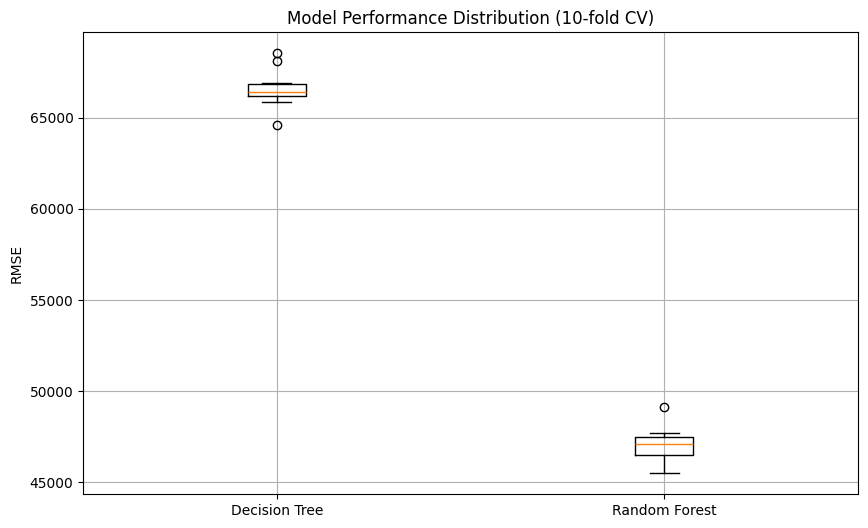

In [14]:
# Create comparison DataFrame
model_comparison = pd.DataFrame({
    "Linear Regression": [lin_rmse],
    "Decision Tree": [tree_rmse_stats['mean']],
    "Random Forest": [forest_rmse_stats['mean']]
})

print("\nModel Comparison (Mean RMSE):")
print(model_comparison)

# Visualize cross-validation distributions
plt.figure(figsize=(10, 6))
plt.boxplot([tree_scores, forest_scores], labels=['Decision Tree', 'Random Forest'])
plt.ylabel('RMSE')
plt.title('Model Performance Distribution (10-fold CV)')
plt.grid(True)
plt.show()